In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_C_over"
plot_title = "train_C_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.829336,0.818299,0.698248,0.818299,0.935434,0.907135,0.893134,0.788386
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.853816,0.844072,0.746580,0.844072,0.946546,0.930731,0.908036,0.843145
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.860859,0.851804,0.752902,0.851804,0.952215,0.937896,0.916739,0.856947
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.863245,0.855026,0.755768,0.855026,0.955429,0.940650,0.921691,0.862575
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.859741,0.850515,0.754937,0.850515,0.953908,0.941797,0.918672,0.863585


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,test,0.829336,0.818299,0.698248,0.818299,0.935434,0.907135,0.893134,0.788386
1,2,test,0.853816,0.844072,0.746580,0.844072,0.946546,0.930731,0.908036,0.843145
2,3,test,0.860859,0.851804,0.752902,0.851804,0.952215,0.937896,0.916739,0.856947
3,4,test,0.863245,0.855026,0.755768,0.855026,0.955429,0.940650,0.921691,0.862575
4,5,test,0.859741,0.850515,0.754937,0.850515,0.953908,0.941797,0.918672,0.863585


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/299:,Train,Loss,=,1.214,Valid,Loss,=,1.185,ETA,=,4.89h
1,Epoch,"1/40,",Batch,20/299:,Train,Loss,=,1.176,Valid,Loss,=,1.142,ETA,=,4.61h
2,Epoch,"1/40,",Batch,30/299:,Train,Loss,=,1.109,Valid,Loss,=,1.115,ETA,=,4.21h
3,Epoch,"1/40,",Batch,40/299:,Train,Loss,=,1.126,Valid,Loss,=,1.048,ETA,=,3.95h
4,Epoch,"1/40,",Batch,50/299:,Train,Loss,=,1.041,Valid,Loss,=,1.031,ETA,=,3.88h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.214,1.185
20,1,20,1.176,1.142
30,1,30,1.109,1.115
40,1,40,1.126,1.048
50,1,50,1.041,1.031


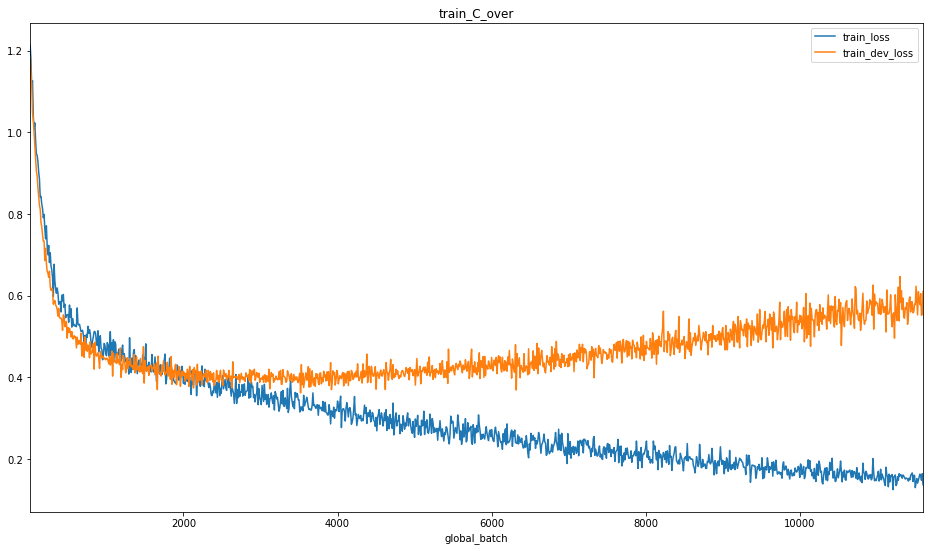

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.841,0.779
2,0.579,0.540
3,0.512,0.479
4,0.471,0.446
5,0.441,0.426


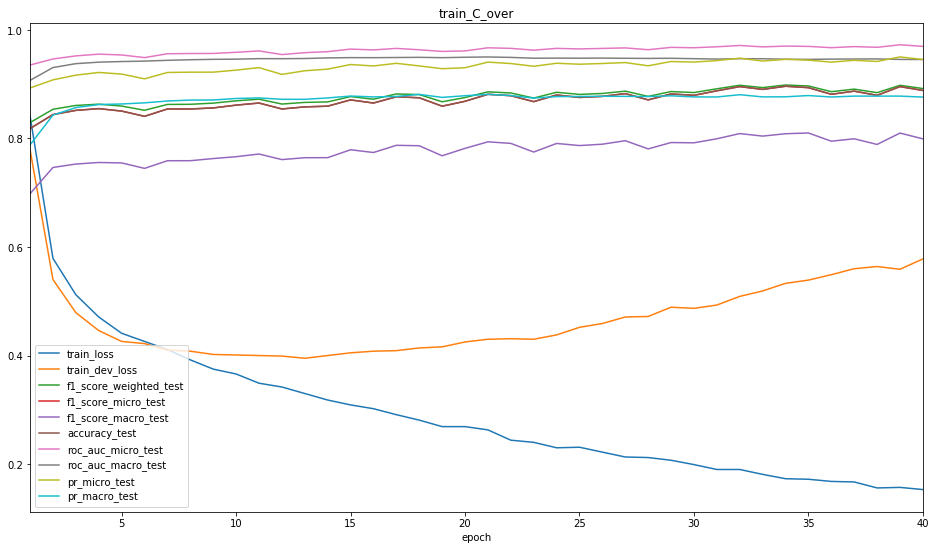

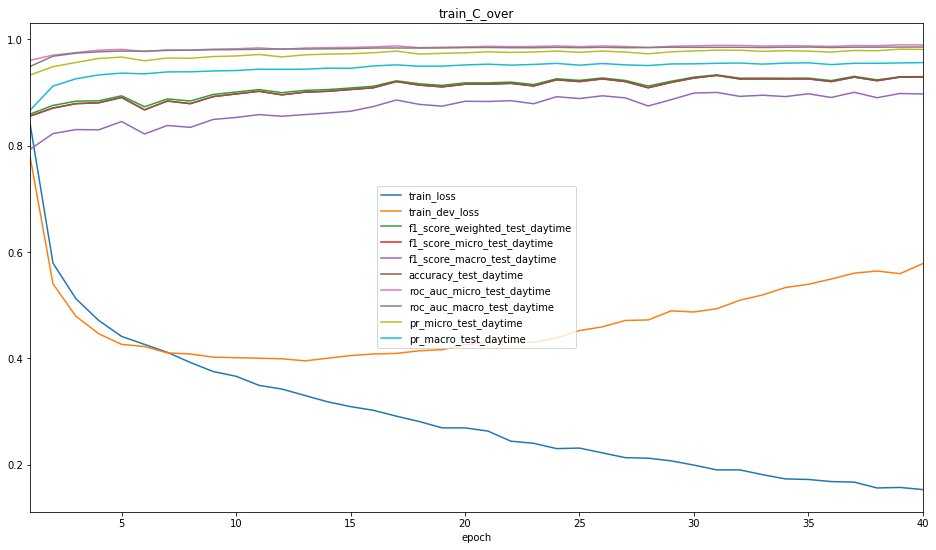

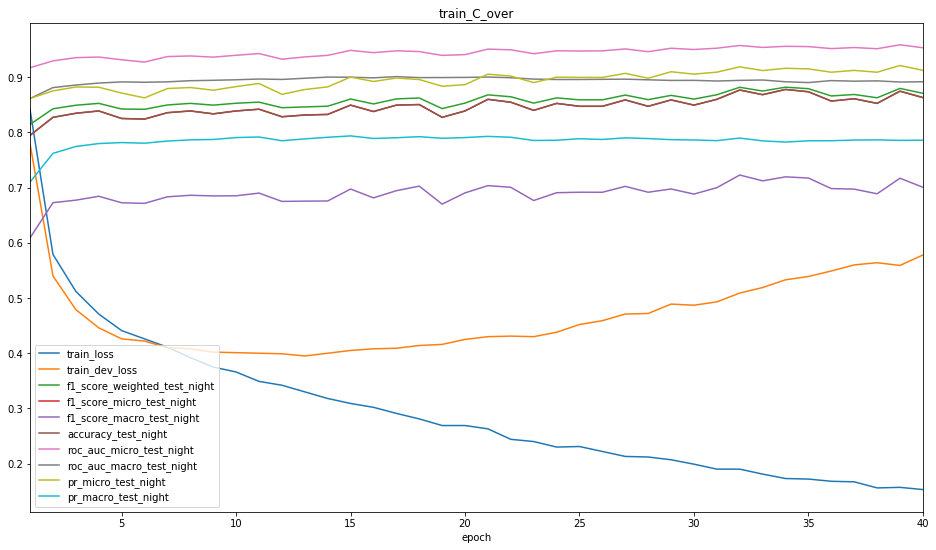

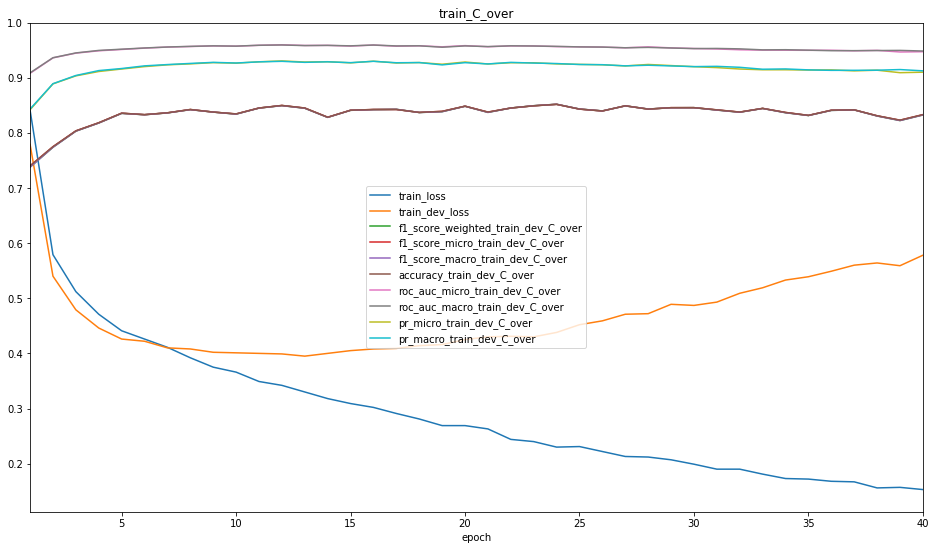

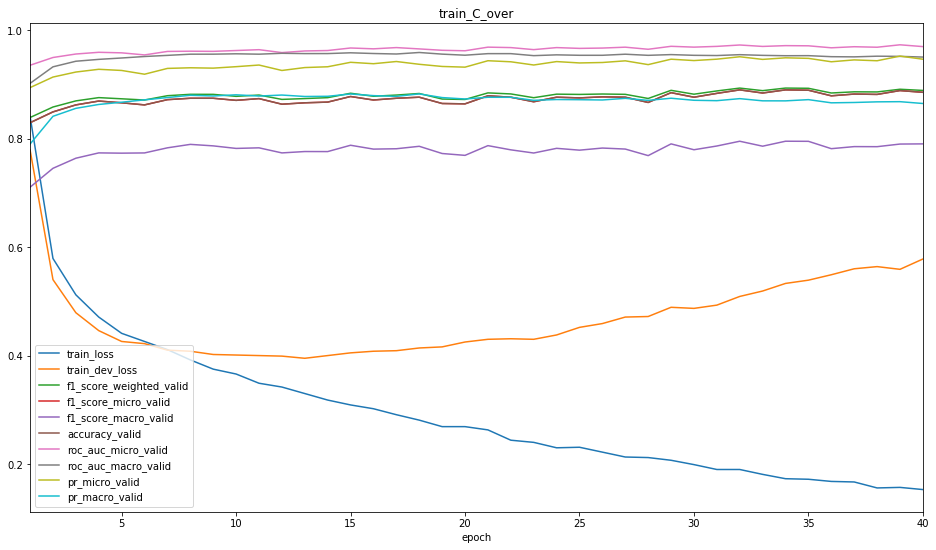

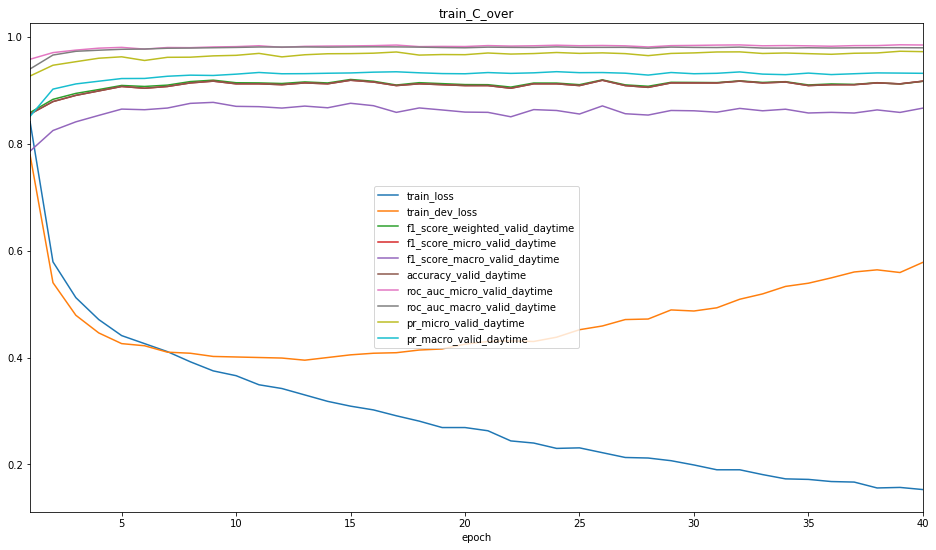

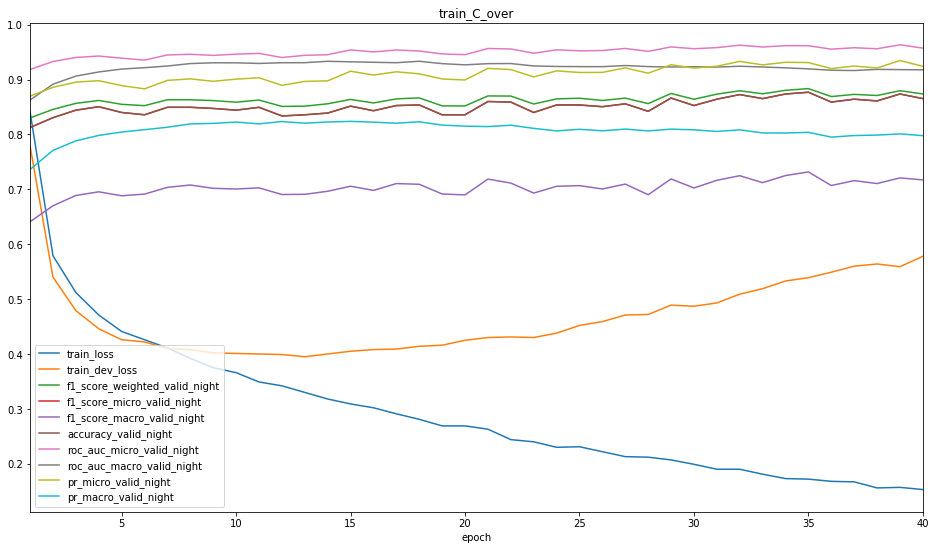

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)